In [1]:
import datetime as dt
import os
import sys
sys.path.append(os.pardir)

import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import pandas as pd

from covid_19.growth_models import GrowthCOVIDModel

In [2]:
def plot_dataframe(df):
    """
    Plot epi data over time.
    
    Parameters
    ----------
    df : pandas.Dataframe
        Epidemiological data in DataFrame format with 4 features:
        date, confirmed_cases, recovered_cases, death_cases
    """
    fig = plt.figure(figsize=(12, 8))
    axs = fig.subplots(nrows=3, ncols=1, sharex=True, squeeze=True)
    axs[0].plot(df.date, df.confirmed_cases, color='blue', linestyle='-', marker='None', label='Confirmed cases')
    axs[0].plot(df.date, df.recovered_cases, color='red', linestyle='-', marker='None', label='Recovered cases')
    axs[0].legend()
    axs[0].grid()
    axs[1].plot(df.date, df.confirmed_cases - df.recovered_cases, color='blue', linestyle='-', marker='None', label='Active cases')
    axs[1].legend()
    axs[1].grid()
    axs[2].plot(df.date, df.death_cases, color='blue', linestyle='-', marker='None', label='Deceased cases')
    axs[2].legend()
    axs[2].grid()
    plt.show()

        date  confirmed_cases  recovered_cases  death_cases
0 2020-02-26              1.0              0.0          0.0
1 2020-02-27              3.0              0.0          0.0
2 2020-02-28              3.0              0.0          0.0
3 2020-02-29              5.0              0.0          0.0
4 2020-03-01              6.0              0.0          0.0 
(...)
           date  confirmed_cases  recovered_cases  death_cases
183 2020-08-27           8888.0           6362.0        175.0
184 2020-08-28           9192.0           6595.0        177.0
185 2020-08-29           9549.0           6809.0        180.0
186 2020-08-30           9861.0           7024.0        183.0
187 2020-08-31          10123.0           7212.0        184.0


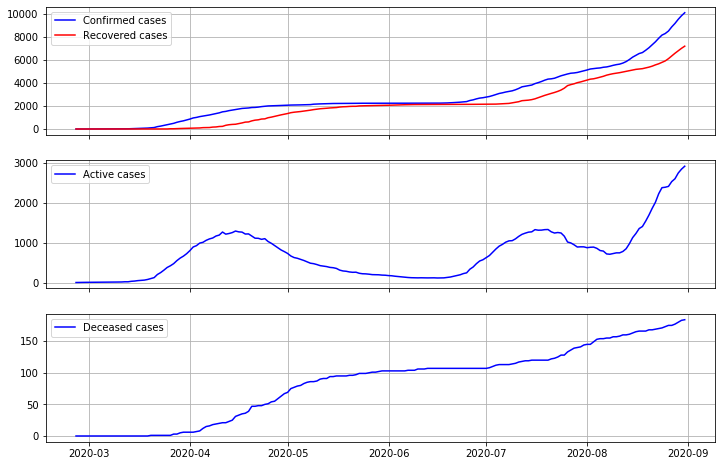

In [3]:
# data
confirmed_cases = np.loadtxt('../data/confirmed_cases.dat')
recovered_cases = np.loadtxt('../data/recovered_cases.dat')
death_cases = np.loadtxt('../data/death_cases.dat')

epidemics_start_date = dt.datetime(2020, 2, 26)
date_list = [epidemics_start_date + dt.timedelta(days=i) for i in range(confirmed_cases.size)]

# full data dataframe
df = pd.DataFrame({
    'date': date_list,
    'confirmed_cases': confirmed_cases,
    'recovered_cases': recovered_cases,
    'death_cases': death_cases,
})
print(df.head(), '\n(...)\n', df.tail())

# visualization of full data
plot_dataframe(df)

        date  confirmed_cases  recovered_cases  death_cases
0 2020-06-02           2246.0           2077.0        103.0
1 2020-06-03           2246.0           2088.0        103.0
2 2020-06-04           2246.0           2095.0        103.0
3 2020-06-05           2247.0           2105.0        103.0
4 2020-06-06           2247.0           2113.0        103.0 
(...)
           date  confirmed_cases  recovered_cases  death_cases
183 2020-08-27           8888.0           6362.0        175.0
184 2020-08-28           9192.0           6595.0        177.0
185 2020-08-29           9549.0           6809.0        180.0
186 2020-08-30           9861.0           7024.0        183.0
187 2020-08-31          10123.0           7212.0        184.0


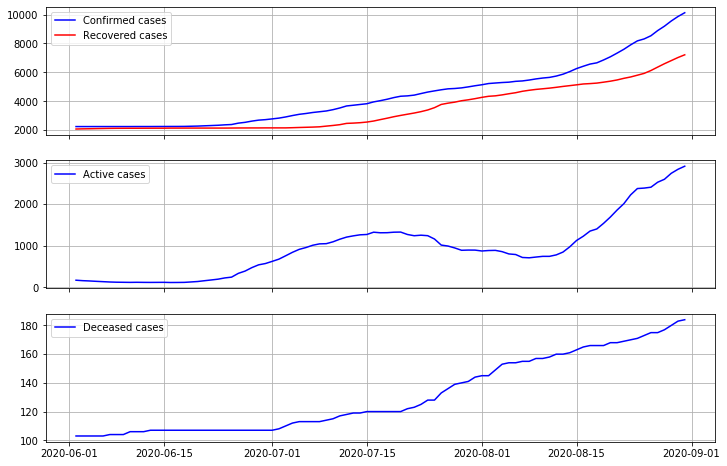

In [4]:
# second wave data dataframe
df_2 = df[df.date>dt.datetime(2020, 6, 1)]
df_2 = df_2.reset_index(drop=True)
print(df_2.head(), '\n(...)\n', df.tail())

# visualization
plot_dataframe(df_2)

In [5]:
def simulate(function, eff_date, confirmed_cases, n_days, plot_confidence_intervals=False, **kwargs):
    """
    Fit the data to exponential function and plot n_days forecast.
        
    Parameters
    ----------
    function : str
        Growth curve.
    eff_date : datetime.datetime
        Start date of simulation.
    confirmed_cases : numpy.ndarray
        Number of confirmed infected COVID-19 cases per day since eff_date.
    n_days : int
        Number of days to extrapolate.
    plot_confidence_intervals : bool, optional
        Plot confidence intervals.
    kwargs
        If specified, keyword arguments are passed to `GrowthCOVIDModel` when ``confidence_interval=True.
    """
    offset = np.min(confirmed_cases)
    confirmed_cases_adjusted = confirmed_cases - offset
    exp_model = GrowthCOVIDModel(function=function, normalize=True, confidence_interval=plot_confidence_intervals, **kwargs)
    x, fitted_curve = exp_model.fit(confirmed_cases_adjusted)
    date_list = [eff_date + dt.timedelta(days=i) for i in range(x.size)]
    x_future, predicted_curve = exp_model.predict(n_days)
    date_list_future = [date_list[-1] + dt.timedelta(days=i) for i in range(x_future.size)]
    props = dict(boxstyle='round', facecolor='lavender', alpha=1.0)
      
    plt.figure(figsize=(12, 8))
    plt.plot(date_list, confirmed_cases_adjusted + offset, color='blue', linestyle='-', marker='o', markersize=9, label='confirmed cases')
    if plot_confidence_intervals:
        plt.plot(date_list, fitted_curve[0, :] + offset, color='red', linestyle='--', marker='None', label=f'lower/upper bound')
        plt.plot(date_list, fitted_curve[1, :] + offset, color='red', linestyle='-', marker='None', label=f'{function} fit')
        plt.plot(date_list, fitted_curve[2, :] + offset, color='red', linestyle='--', marker='None')
        plt.fill_between(date_list, fitted_curve[0, :] + offset, fitted_curve[2, :] + offset, color='red', alpha=0.1)
        
        plt.plot(date_list_future, predicted_curve[0, :] + offset, color='red', linestyle='--', marker='None')
        plt.plot(date_list_future, predicted_curve[1, :] + offset, color='red', linestyle='-', marker='o',  label='extrapolated curve')
        plt.plot(date_list_future, predicted_curve[2, :] + offset, color='red', linestyle='--', marker='None')
        plt.fill_between(date_list_future, predicted_curve[0, :] + offset, predicted_curve[2, :] + offset, color='red', alpha=0.1)
        
        for idx, vals in enumerate(zip(date_list_future[1:], predicted_curve[1, 1:] + offset)):
            plt.text(vals[0], vals[1] - 175, str(int(vals[1])), verticalalignment='top', bbox=props)
    else:
        plt.plot(date_list, fitted_curve + offset, color='red', linestyle='-', marker='None', label=f'{function} fit')
        
        plt.plot(date_list_future, predicted_curve + offset, color='red', linestyle='--', marker='o',  label='extrapolated curve')
        
        for idx, vals in enumerate(zip(date_list_future[1:], predicted_curve[1:] + offset)):
            plt.text(vals[0], vals[1] - 175, str(int(vals[1])), verticalalignment='top', bbox=props)
    plt.legend()
    plt.grid()
    plt.gcf().autofmt_xdate()
    plt.show()

In [6]:
eff_date = dt.datetime(2020, 8, 1)
confirmed_cases = df_2[df_2.date > eff_date].confirmed_cases.values
n_days = 7

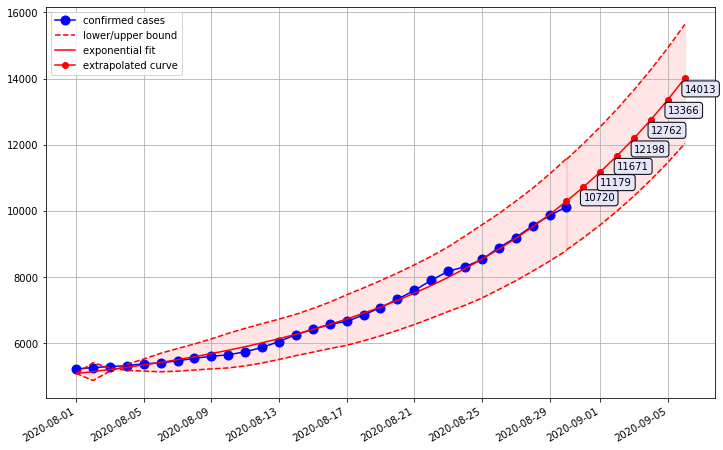

In [7]:
simulate(
    function='exponential', 
    eff_date=eff_date, 
    confirmed_cases=confirmed_cases, 
    n_days=n_days, 
    plot_confidence_intervals=True, 
    sensitivity=0.98, ci_level=95
)

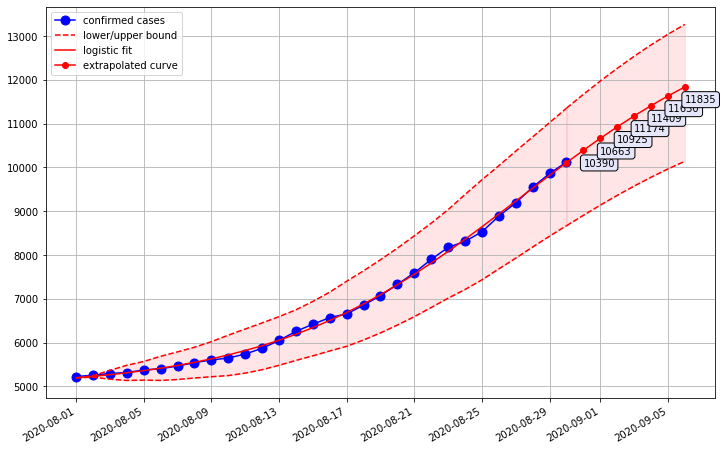

In [8]:
simulate(
    function='logistic', 
    eff_date=eff_date, 
    confirmed_cases=confirmed_cases, 
    n_days=n_days, 
    plot_confidence_intervals=True, 
    sensitivity=0.98, ci_level=95
)